Note: To be able to run this you need to have the dataset uploaded on your drive as a zip file.

You can find it here:
https://www.kaggle.com/datasets/denizkavi1/brain-tumor/data

In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the file
!unzip /content/drive/MyDrive/archive.zip

In [ ]:
# Needed imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2
import shutil
from tqdm import tqdm

In [ ]:
# Create a new folder to combine the three folders
folder_name = "input folder"
folder_path = "/content/" + folder_name

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Folder created successfully!")
else:
    print("Folder already exists.")

Folder created successfully!


In [ ]:
# Move the three folders to the new folder
source_folders = ["/content/1", "/content/2", "/content/3"]
destination_folder = "/content/input folder"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print("Destination folder created successfully!")

for source_folder in source_folders:
    if os.path.exists(source_folder):
        folder_name = os.path.basename(source_folder)
        destination_path = os.path.join(destination_folder, folder_name)
        shutil.move(source_folder, destination_path)
        print(f"Folder '{folder_name}' moved successfully!")
    else:
        print(f"Source folder '{source_folder}' does not exist.")

Folder '1' moved successfully!
Folder '2' moved successfully!
Folder '3' moved successfully!


In [ ]:
# Define the folder name and the tumor types
data_folder = "/content/input folder"
tumor_types = ["meningioma", "glioma", "pituitary"]

# Create arrays for the images and labels
image_paths = []
labels = []

In [ ]:
# Define functions for image preprocessing
def preprocess_image(img_path, resize_dim=(224, 224), convert_to_gray=False):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is not None:
        if convert_to_gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if resize_dim:
            img = cv2.resize(img, resize_dim)
    return img
def load_images_from_folder(folder, resize_dim=(224, 224), convert_to_gray=False):
    images = []
    labels = []
    for tumor_type_idx, tumor_type in enumerate(tumor_types, start=1):
        tumor_folder = os.path.join(folder, str(tumor_type_idx))
        for filename in tqdm(os.listdir(tumor_folder), desc=f"Loading {tumor_type} images"):
            img_path = os.path.join(tumor_folder, filename)
            img = preprocess_image(img_path, resize_dim=resize_dim, convert_to_gray=convert_to_gray)
            if img is not None:
                images.append(img)
                labels.append(tumor_type)
    return images, labels

In [ ]:
# Load and preprocess images
images, labels = load_images_from_folder(data_folder, resize_dim=(224, 224), convert_to_gray=True)

# Convert images to RGB if they are in grayscale
rgb_img = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in images]

# Convert lists to NumPy arrays
images_array = np.array(rgb_img)
labels_array = np.array(labels)

Loading pituitary images: 100%|██████████| 930/930 [00:14<00:00, 63.70it/s]


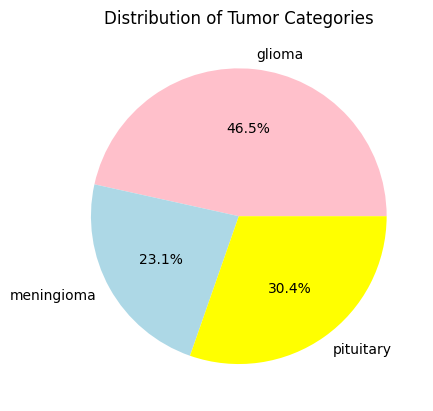

In [ ]:
# Show Diagram of Tumor Categories
unique_labels, counts = np.unique(labels, return_counts=True)

# Define a color palette with pink, blue, and yellow
colors = ['#FFC0CB', '#ADD8E6', '#FFFF00']

plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Tumor Categories')
plt.show()

In [ ]:
#Split Dataset into Training and Testing Sets
train_images, test_images, train_labels, test_labels = train_test_split(rgb_img, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
# model
# Load the ResNet50 model
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=len(tumor_types)):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the top layers for classification
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the model
model = create_resnet50_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Convert labels to one-hot encoded vectors
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)


In [ ]:
# Train the model

model.fit(np.array(train_images), train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 632s 10s/step - loss: 12.3375 - accuracy: 0.7449 - val_loss: 0.8258 - val_accuracy: 0.8330
Epoch 2/10
62/62 [==============================] - 632s 10s/step - loss: 0.4313 - accuracy: 0.8520 - val_loss: 0.5869 - val_accuracy: 0.8574
Epoch 3/10
62/62 [==============================] - 635s 10s/step - loss: 0.3518 - accuracy: 0.8607 - val_loss: 0.7330 - val_accuracy: 0.8411
Epoch 4/10
62/62 [==============================] - 599s 10s/step - loss: 0.3586 - accuracy: 0.8694 - val_loss: 0.4790 - val_accuracy: 0.8900
Epoch 5/10
62/62 [==============================] - 607s 10s/step - loss: 0.2450 - accuracy: 0.9041 - val_loss: 0.4903 - val_accuracy: 0.8737
Epoch 6/10
62/62 [==============================] - 624s 10s/step - loss: 0.2358 - accuracy: 0.9036 - val_loss: 0.4782 - val_accuracy: 0.8961
Epoch 7/10
62/62 [==============================] - 618s 10s/step - loss: 0.2093 - accuracy: 0.9214 - val_loss: 0.5247 - val_accuracy: 0.9063
Epoch

In [ ]:
# Test the model's performance

test_loss, test_accuracy = model.evaluate(np.array(test_images), test_labels_one_hot)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

20/20 [==============================] - 136s 7s/step - loss: 0.3605 - accuracy: 0.9233
Test Loss: 0.3605, Test Accuracy: 0.9233


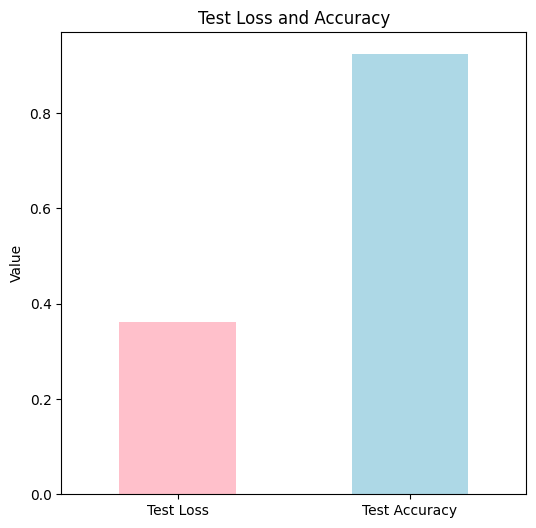

In [ ]:
# Visualize the test loss and accuracy

# Set the width of the bars
bar_width = 0.5

# Set the positions of the bars on the x-axis
bar_positions = np.arange(2)

# Plotting the test loss and accuracy
plt.figure(figsize=(6, 6))
plt.bar(bar_positions, [test_loss, test_accuracy], width=bar_width, color=['#FFC0CB', '#ADD8E6'])

# Adjusting the x-tick labels position
plt.xticks(bar_positions, ['Test Loss', 'Test Accuracy'])
plt.xlim(-0.5, 1.5)

# Adding labels and title
plt.ylabel('Value')
plt.title('Test Loss and Accuracy')

plt.show()